## Functions

In [11]:
import pandas as pd
import numpy as np

import math
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [12]:
def logNBdensity(k,m,r):
  eps = 1.e-10
  c = 1./(r+m+eps)
  x = torch.lgamma(k+r) - torch.lgamma(r) - torch.lgamma(k+1) + k*torch.log(m*c+eps) + r*torch.log(r*c)
  return x

class NBLayer(nn.Module):
    def __init__(self, out_dim, r_init, scaling_type='library',reduction='sum'):
        super(NBLayer, self).__init__()

        self.log_r = torch.nn.Parameter(torch.full(fill_value=math.log(r_init), size=(1,out_dim)), requires_grad=True)
        if scaling_type in ['library','total_count']:
            self.activation = 'sigmoid'
        elif scaling_type in ['mean','median']:
            self.activation = 'softplus'
        else:
            raise ValueError('Unknown scaling type specified. Please use one of: "library", "total_count", "mean", or "median".')
        self.reduction = reduction

    def forward(self, x):
        if self.activation == 'sigmoid':
            return torch.sigmoid(x)
        else:
            return F.softplus(x)

    def rescale(self,M,mhat):
        return M*mhat

    def loss(self,x,M,mhat):
        if self.reduction == 'none':
            return -logNBdensity(x,self.rescale(M,mhat),torch.exp(self.log_r))
        elif self.reduction == 'sum':
            return -logNBdensity(x,self.rescale(M,mhat),torch.exp(self.log_r)).sum()

    def logprob(self,x,M,mhat):
        return logNBdensity(x,self.rescale(M,mhat),torch.exp(self.log_r))

    def sample(self,nsample,M,mhat):
        with torch.no_grad():
            m = self.rescale(M,mhat)
            probs = m/(m+torch.exp(self.log_r))
            nb = torch.distributions.NegativeBinomial(torch.exp(self.log_r), probs=probs)
            return nb.sample([nsample]).squeeze()
        
class Decoder(nn.Module):
    def __init__(self, latent, hidden, out, r_init=2, scaling_type='library', dropout_rate=0, activation='relu'):
        super(Decoder, self).__init__()

        self.main = nn.ModuleList()

        # Handle different activation functions
        if activation == 'relu':
            self.activation = nn.ReLU(True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2, True)
        elif activation == 'elu':
            self.activation = nn.ELU(True)
        else:
            raise ValueError('Unknown activation function specified. Please use one of: "relu", "leaky_relu", "elu".')

        if isinstance(hidden, list):
            n_hidden = len(hidden)
            self.main.append(nn.Linear(latent, hidden[0]))
            self.main.append(self.activation)
            self.main.append(nn.Dropout(dropout_rate))
            self.main.append(nn.BatchNorm1d(hidden[0]))
            for i in range(n_hidden - 1):
                self.main.append(nn.Linear(hidden[i], hidden[i + 1]))
                self.main.append(self.activation)
                self.main.append(nn.Dropout(dropout_rate))
                self.main.append(nn.BatchNorm1d(hidden[i + 1]))
            self.main.append(nn.Linear(hidden[-1], out))
        else:
            self.main.append(nn.Linear(latent, hidden))
            self.main.append(self.activation)
            self.main.append(nn.Dropout(dropout_rate))
            self.main.append(nn.BatchNorm1d(hidden))
            self.main.append(nn.Linear(hidden, out))

        self.nb = NBLayer(out, r_init=r_init, scaling_type=scaling_type)

    def forward(self, z):
        for layer in self.main:
            z = layer(z)
        return self.nb(z)

In [13]:
# reload the imports
import importlib
import utils.metrics
importlib.reload(utils.metrics)
import utils.gmm
importlib.reload(utils.gmm)

from utils.metrics import ClusteringMetrics
from utils.gmm import GaussianMixture
from utils.representation_layer import RepresentationLayer

## Toy bulk gene expression data

I just took TCGA data from Recount like Anders did somewhere.

Data at https://jhubiostatistics.shinyapps.io/recount3-study-explorer/

Using small set of 178 samples and 64000 genes:
LAML=Acute Myeloid Leukemia

label
breast invasive carcinoma         1142
Muscle - Skeletal                  881
Whole Blood                        852
Skin - Sun Exposed (Lower leg)     781
Adipose - Subcutaneous             731
                                  ... 
Bladder                             21
Cervix - Endocervix                 10
Fallopian Tube                       9
Cervix - Ectocervix                  9
Kidney - Medulla                     4
Name: count, Length: 70, dtype: int64


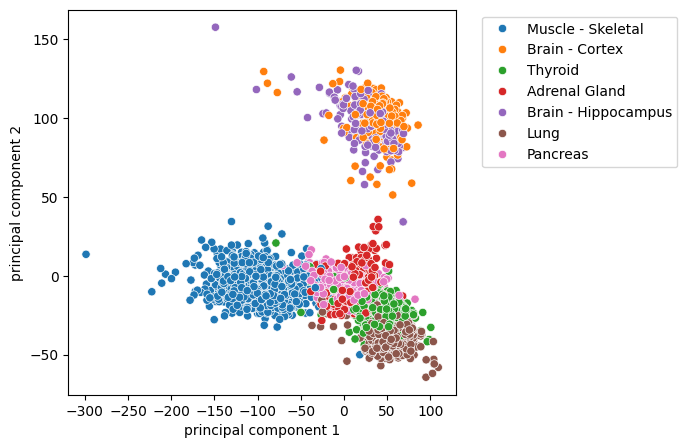

Number of samples in train set: 2705
Number of samples in test set: 677
tensor([[8.9374e+04, 1.8939e+04, 1.7846e+04,  ..., 1.2763e+05, 7.4030e+04,
         5.1391e+04],
        [2.3808e+05, 2.6800e+05, 7.3140e+03,  ..., 2.4051e+05, 4.8709e+05,
         1.4513e+05],
        [2.1675e+05, 1.4001e+05, 1.5200e+02,  ..., 2.7994e+05, 2.7603e+05,
         1.3479e+05],
        ...,
        [5.4545e+04, 2.4862e+04, 0.0000e+00,  ..., 1.0659e+05, 1.1501e+05,
         3.6198e+04],
        [2.6376e+05, 7.5554e+04, 0.0000e+00,  ..., 2.2747e+05, 7.8148e+05,
         1.0725e+05],
        [2.8458e+05, 1.0668e+05, 6.0000e+01,  ..., 1.9091e+05, 5.0313e+05,
         8.9753e+04]], device='cuda:0')


In [14]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

class GeneExpressionDataset(Dataset):
    def __init__(self, gtex, label_position=-1, scaling_type='mean'):
        self.scaling_type = scaling_type
        self.label_position = label_position

        # convert labels to numbers
        self.label = gtex.iloc[:, label_position].values
        self.data = torch.tensor(gtex.drop(gtex.columns[[self.label_position]], axis=1).select_dtypes(include=[np.number]).values).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx=None):
        if idx is None:
            idx = np.arange(self.__len__())
        expression = self.data[idx, :]
        if self.scaling_type == 'mean':
            lib = torch.mean(expression, dim=-1)
        elif self.scaling_type == 'max':
            lib = torch.max(expression, dim=-1).values
        return expression.to(device), lib.to(device), idx

    def __getlabel__(self, idx=None):
        if idx is None:
            idx = np.arange(self.__len__())
        return torch.tensor(self.label[idx]).to(device)

# Download and prepare the data
# !wget https://zenodo.org/record/7828660/files/gtex_with_cancer.csv.gz

data = pd.read_csv("gtex_with_cancer.csv.gz", sep="\t")
# Use tissue types as labels
data['label'] = data['tissue']

print(data['label'].value_counts())

# Filter tissues
gtex_raw_total = data[data['tissue'].isin(['Muscle - Skeletal', 'Brain - Cortex', 'Brain - Hippocampus', 'Adrenal Gland', 'Thyroid', 'Lung', 'Pancreas'])]

# Reduce to 3382 rows
gtex_raw = gtex_raw_total.sample(3382, random_state=42)

# Drop columns with only zeros
gtex_raw = gtex_raw.loc[:, (gtex_raw != 0).any(axis=0)]

# Filter tissues and ensure the 'label' column reflects tissue types:
tissue_to_label = {tissue: idx for idx, tissue in enumerate(gtex_raw['tissue'].unique())}
gtex_raw['label'] = gtex_raw['tissue'].map(tissue_to_label)

# Ensure 'label' is included before splitting
x = gtex_raw.loc[:, ~gtex_raw.columns.isin(['tissue', 'label'])].values
x = np.log(x + 0.01)  # add pseudo-counts

# PCA for visualization (optional)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df_pca = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])
df_pca['tissue'] = gtex_raw['tissue'].values

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=df_pca, x='principal component 1', y='principal component 2', hue='tissue', ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1.), loc='upper left')
plt.show()

# Convert tissue labels to numerical labels
tissue_to_label = {tissue: idx for idx, tissue in enumerate(gtex_raw['tissue'].unique())}
gtex_raw['label'] = gtex_raw['tissue'].map(tissue_to_label)

# Ensure 'label' is included before splitting
gtex_raw['label'] = gtex_raw['label'].astype(int)

# Make data split for train and validation sets
gtex_raw = shuffle(gtex_raw)
out_dim = gtex_raw.shape[1] - 2  # Exclude 'tissue' and 'label'

train_ratio = 0.8
train_data = gtex_raw.iloc[:int(train_ratio * len(gtex_raw)), :].copy()
test_data = gtex_raw.iloc[int(train_ratio * len(gtex_raw)):, :].copy()

# Define scaling for NB
scaling_factors = torch.mean(torch.tensor(train_data.iloc[:, :-2].to_numpy(), dtype=torch.float32), dim=-1).unsqueeze(1)
test_scaling_factors = torch.mean(torch.tensor(test_data.iloc[:, :-2].to_numpy(), dtype=torch.float32), dim=-1).unsqueeze(1)

# Make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data),
                                           batch_size=256,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data),
                                          batch_size=256,
                                          shuffle=False)

print('Number of samples in train set:', len(train_data))
print('Number of samples in test set:', len(test_data))
print(train_loader.dataset.data.to(device))


In [15]:
import torch
from matplotlib.patches import Ellipse
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def match_labels(y_true, y_pred):
    contingency_matrix = torch.zeros((y_true.max() + 1, y_pred.max() + 1), dtype=torch.int32).to(device)
    for i in range(y_true.size(0)):
        contingency_matrix[y_true[i], y_pred[i]] += 1

    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.cpu().numpy())

    label_mapping = {col: row for row, col in zip(row_ind, col_ind)}

    matched_labels = torch.tensor([label_mapping[label.item()] for label in y_pred], dtype=torch.int64).to(device)
    return matched_labels

def plot_clustering(X, y_true, y_pred, means, covariances, ax, scores=None):
    y_pred = match_labels(y_true, y_pred)

    correct = y_true == y_pred
    incorrect = y_true != y_pred

    ax.scatter(X[correct].detach()[:, 0].cpu(), X[correct].detach()[:, 1].cpu(), c='lightblue', label='Correct prediction', s=5)
    ax.scatter(X[incorrect].detach()[:, 0].cpu(), X[incorrect].detach()[:, 1].cpu(), c='red', label='Incorrect prediction', s=5)

    for i in range(means.shape[0]):
        mean = means[i].detach().cpu().numpy()
        cov = covariances[i].detach().cpu().numpy()
        cov = np.diag(cov) if cov.ndim == 1 else cov

        ax.scatter(mean[0], mean[1], c='black', marker='x', label=f'Mean' if i == 0 else "")

        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * np.sqrt(eigvals[:2])
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
        ax.add_patch(ell)

    ax.legend()
    ax.set_title('Clustering Results')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')


def plot_gaussian(X, y_true, y_pred, means, covariances, train_losses, test_losses, gmm_train_losses, gmm_test_losses, recon_train_losses, recon_test_losses):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Hexbin plot of the reconstructions
    axs[0, 0].hexbin(X.detach()[:, 0].cpu(), X.detach()[:, 1].cpu(), gridsize=50, cmap='Blues')
    for i in range(means.shape[0]):
        mean = means[i].detach().cpu().numpy()
        cov = covariances[i].detach().cpu().numpy()
        cov = np.diag(cov) if cov.ndim == 1 else cov

        eigvals, eigvecs = np.linalg.eigh(cov)
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * np.sqrt(eigvals[:2])
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='black', facecolor='none', linestyle='--')
        axs[0, 0].add_patch(ell)
        axs[0, 0].scatter(mean[0], mean[1], c='black', marker='x')
    axs[0, 0].set_title('Hex Plot of Reconstructions')

    # Scatter plot of the reconstructions and means of the GMM with different colors for each cluster
    colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']
    axs[0, 1].scatter(X.detach()[:, 0].cpu(), X.detach()[:, 1].cpu(), s=5, c=[colors[i%len(colors)] for i in y_pred.detach().cpu()], alpha=0.5, label='Reconstruction')
    for i in range(means.shape[0]):
        mean = means[i].detach().cpu().numpy()
        axs[0, 1].scatter(mean[0], mean[1], c='black', marker='x', label='GMM Mean' if i == 0 else "")
    axs[0, 1].set_title('Reconstructions with GMM Means')
    axs[0, 1].legend()

    # Plot of the reconstructed clusters with incorrect predictions
    plot_clustering(X, y_true, y_pred, means, covariances, ax=axs[0, 2])

    # Ensure the same scale for x and y across all top plots
    for ax in axs[0, :]:
        ax.set_xlim(X.detach()[:, 0].cpu().min(), X.detach()[:, 0].cpu().max())
        ax.set_ylim(X.detach()[:, 1].cpu().min(), X.detach()[:, 1].cpu().max())

    # Loss plots with dotted and dashed lines, exclude the first epoch
    epochs = range(1, len(train_losses))
    axs[1, 0].plot(epochs, train_losses[1:], 'o--', label='Train Loss')
    axs[1, 0].plot(epochs, test_losses[1:], 'o--', label='Test Loss')
    axs[1, 0].set_title('Total Loss')
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, gmm_train_losses[1:], 'o--', label='GMM Train Loss')
    axs[1, 1].plot(epochs, gmm_test_losses[1:], 'o--', label='GMM Test Loss')
    axs[1, 1].set_title('GMM Loss')
    axs[1, 1].legend()

    axs[1, 2].plot(epochs, recon_train_losses[1:], 'o--', label='Reconstruction Train Loss')
    axs[1, 2].plot(epochs, recon_test_losses[1:], 'o--', label='Reconstruction Test Loss')
    axs[1, 2].set_title('Reconstruction Loss')
    axs[1, 2].legend()

    plt.tight_layout()
    plt.show()

### training

5002


 20%|█▉        | 99/501 [01:17<05:15,  1.27it/s]

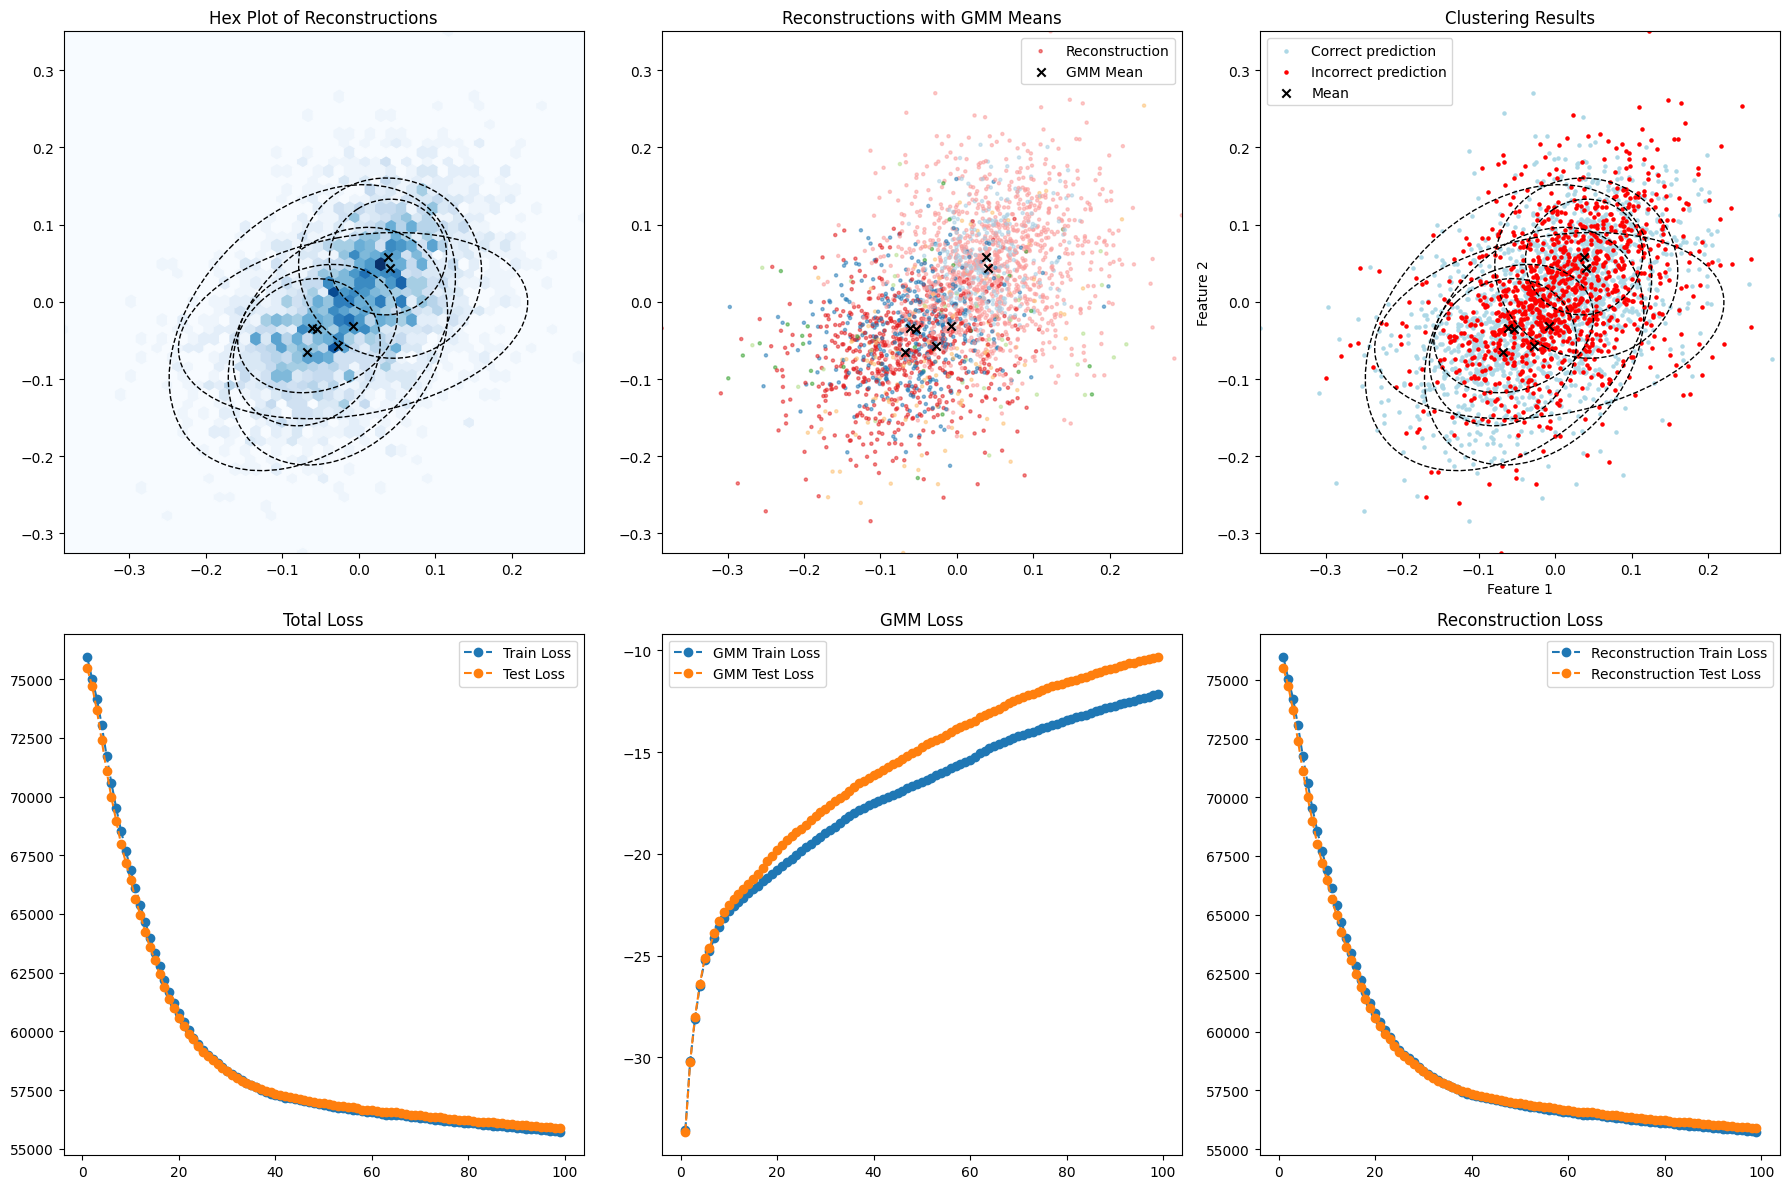

 20%|█▉        | 100/501 [01:19<07:34,  1.13s/it]

{'rand_score': 0.7894871830940247, 'adjusted_rand_score': 0.4176613390445709, 'mutual_info_score': 0.9441704750061035, 'adjusted_mutual_info_score': 0.5722785592079163, 'normalized_mutual_info_score': 0.5725365281105042, 'fowlkes_mallows_score': 0.5601449012756348, 'homogeneity_score': 0.4078766107559204, 'completeness_score': 0.7063300609588623, 'v_measure_score': 0.5171311905636673, 'purity_score': 0.631053626537323, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.42360198497772217}, 1: {'precision': 0.5365239294710328, 'recall': 0.9260869565217391, 'f1-score': 0.6794258373205743, 'support': 230, 'jaccard': 0.5144927536231884, 'roc_auc': 0.9234746694564819}, 2: {'precision': 0.35135135135135137, 'recall': 0.02276707530647986, 'f1-score': 0.04276315789473684, 'support': 571, 'jaccard': 0.021848739495798318, 'roc_auc': 0.5043963193893433}, 3: {'precision': 0.030303030303030304, 'recall': 0.004524886877828055, 

 30%|██▉       | 149/501 [01:56<04:22,  1.34it/s]

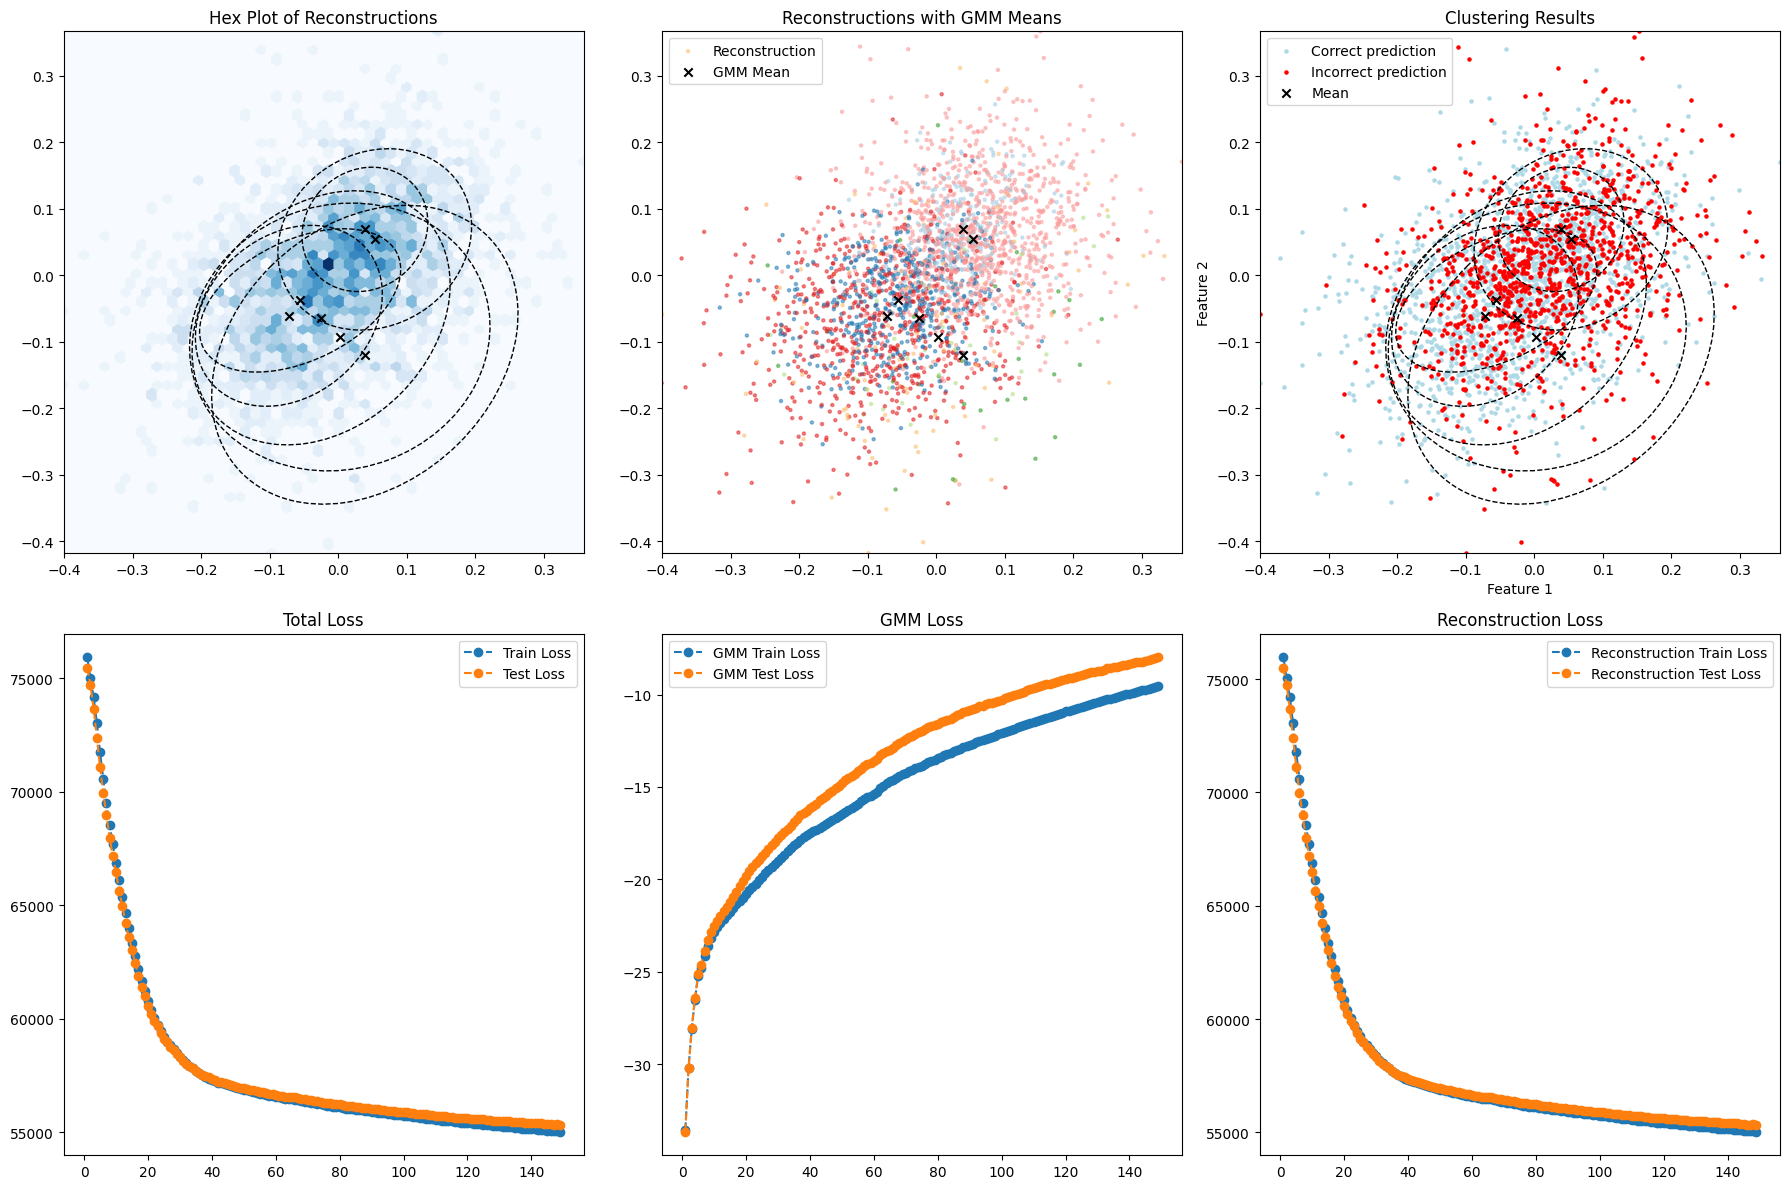

 30%|██▉       | 150/501 [01:58<06:58,  1.19s/it]

{'rand_score': 0.8049601316452026, 'adjusted_rand_score': 0.4457424283027649, 'mutual_info_score': 0.9098131656646729, 'adjusted_mutual_info_score': 0.5494256615638733, 'normalized_mutual_info_score': 0.5496987104415894, 'fowlkes_mallows_score': 0.5766555070877075, 'homogeneity_score': 0.3896030783653259, 'completeness_score': 0.6808412671089172, 'v_measure_score': 0.4956032598336816, 'purity_score': 0.6144177317619324, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.42543309926986694}, 1: {'precision': 0.40784313725490196, 'recall': 0.9043478260869565, 'f1-score': 0.5621621621621622, 'support': 230, 'jaccard': 0.39097744360902253, 'roc_auc': 0.8938323259353638}, 2: {'precision': 0.15384615384615385, 'recall': 0.010507880910683012, 'f1-score': 0.019672131147540985, 'support': 571, 'jaccard': 0.009933774834437087, 'roc_auc': 0.49546414613723755}, 3: {'precision': 0.03571428571428571, 'recall': 0.004524886877828

 40%|███▉      | 199/501 [02:28<02:06,  2.39it/s]

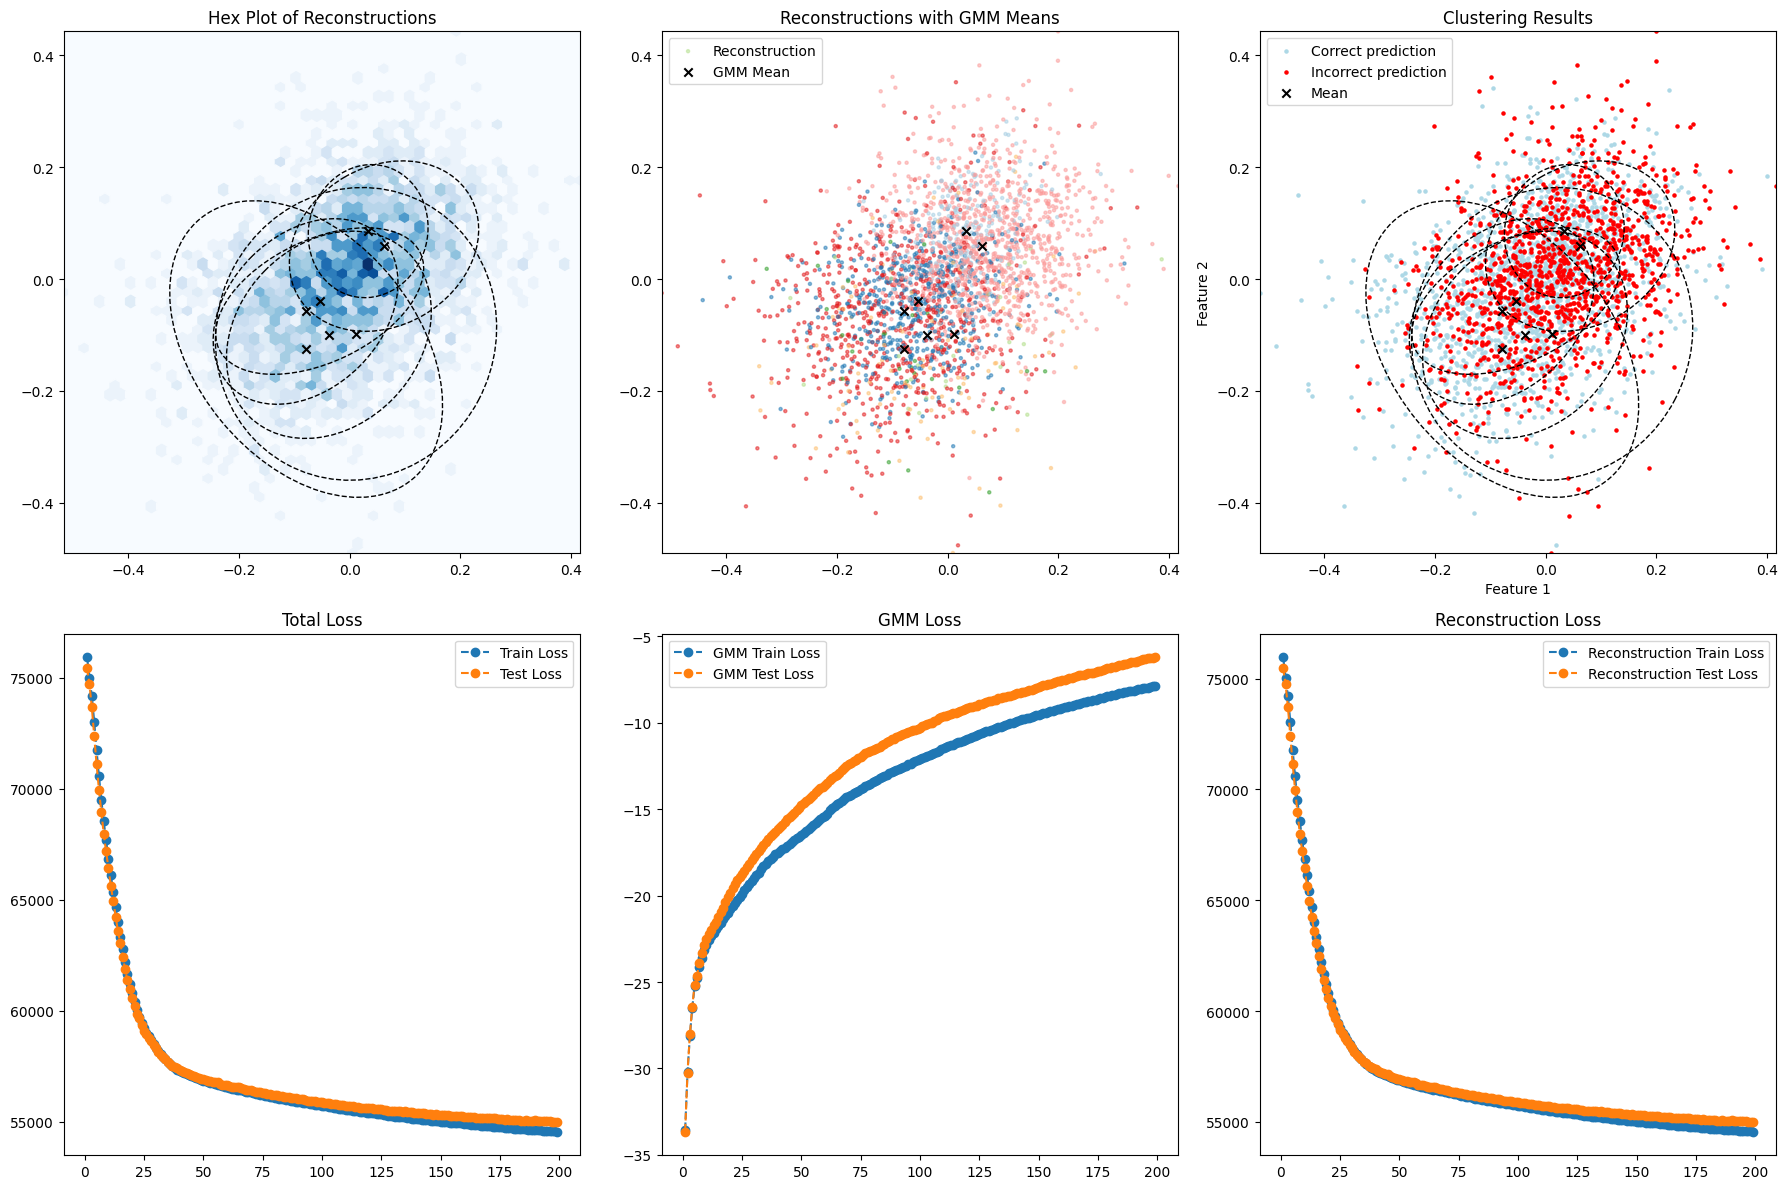

 40%|███▉      | 200/501 [02:30<03:56,  1.27it/s]

{'rand_score': 0.7869666814804077, 'adjusted_rand_score': 0.4019084572792053, 'mutual_info_score': 0.8553289175033569, 'adjusted_mutual_info_score': 0.5208617448806763, 'normalized_mutual_info_score': 0.5211490392684937, 'fowlkes_mallows_score': 0.5442197322845459, 'homogeneity_score': 0.34077709913253784, 'completeness_score': 0.6661502122879028, 'v_measure_score': 0.45089399076833403, 'purity_score': 0.5767098069190979, 'classification_report': {0: {'precision': 0.004651162790697674, 'recall': 0.001388888888888889, 'f1-score': 0.0021390374331550803, 'support': 720, 'jaccard': 0.0010706638115631692, 'roc_auc': 0.4378715455532074}, 1: {'precision': 0.3614678899082569, 'recall': 0.8565217391304348, 'f1-score': 0.5083870967741936, 'support': 230, 'jaccard': 0.3408304498269896, 'roc_auc': 0.8499341011047363}, 2: {'precision': 0.1111111111111111, 'recall': 0.005253940455341506, 'f1-score': 0.010033444816053514, 'support': 571, 'jaccard': 0.005042016806722689, 'roc_auc': 0.49735501408576965

 50%|████▉     | 249/501 [02:51<01:39,  2.53it/s]

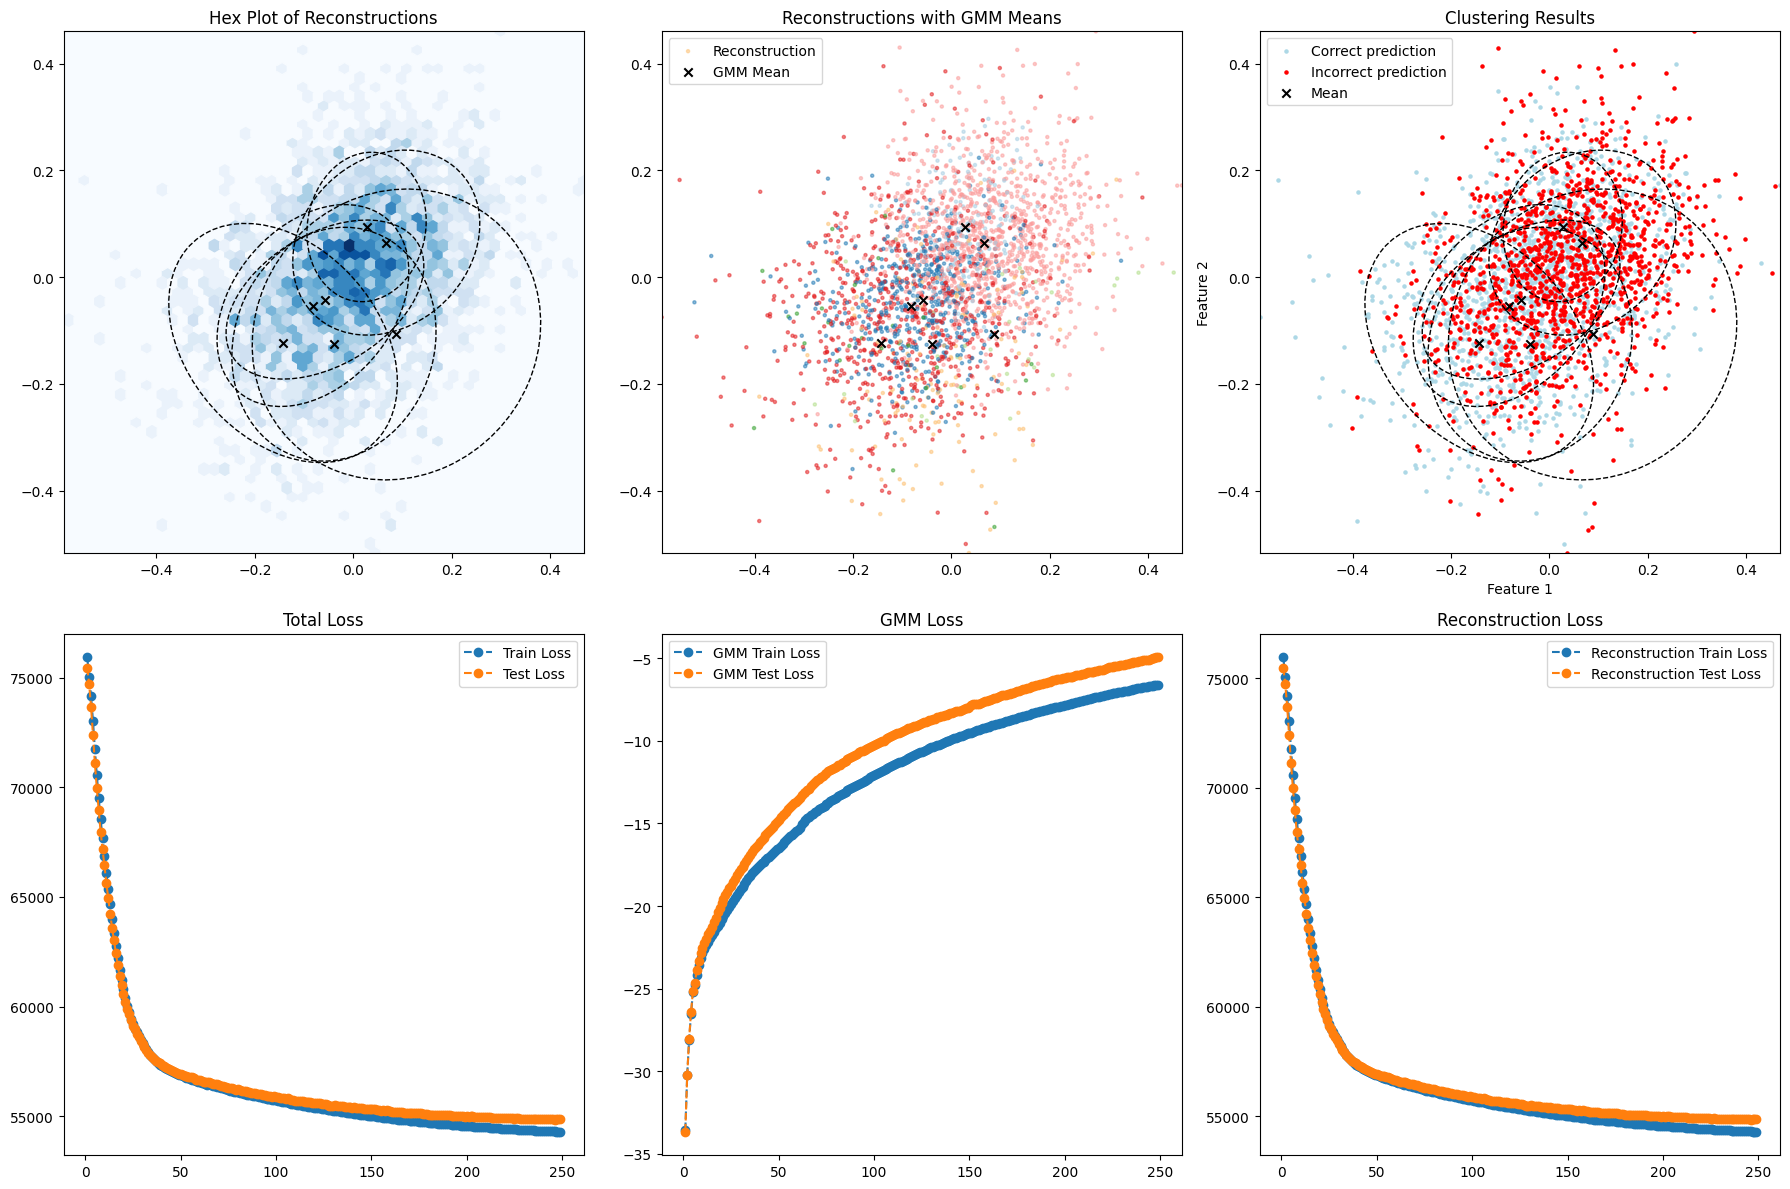

 50%|████▉     | 250/501 [02:52<03:25,  1.22it/s]

{'rand_score': 0.7736243605613708, 'adjusted_rand_score': 0.36749064922332764, 'mutual_info_score': 0.801525354385376, 'adjusted_mutual_info_score': 0.4884624183177948, 'normalized_mutual_info_score': 0.4887688457965851, 'fowlkes_mallows_score': 0.5177321434020996, 'homogeneity_score': 0.3027089238166809, 'completeness_score': 0.6380664110183716, 'v_measure_score': 0.4106153498099698, 'purity_score': 0.5482439994812012, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.4488210380077362}, 1: {'precision': 0.3592233009708738, 'recall': 0.8043478260869565, 'f1-score': 0.49664429530201337, 'support': 230, 'jaccard': 0.33035714285714285, 'roc_auc': 0.8308335542678833}, 2: {'precision': 0.17857142857142858, 'recall': 0.008756567425569177, 'f1-score': 0.01669449081803005, 'support': 571, 'jaccard': 0.008417508417508417, 'roc_auc': 0.5000073909759521}, 3: {'precision': 0.037037037037037035, 'recall': 0.00452488687782805

 60%|█████▉    | 299/501 [03:30<02:31,  1.33it/s]

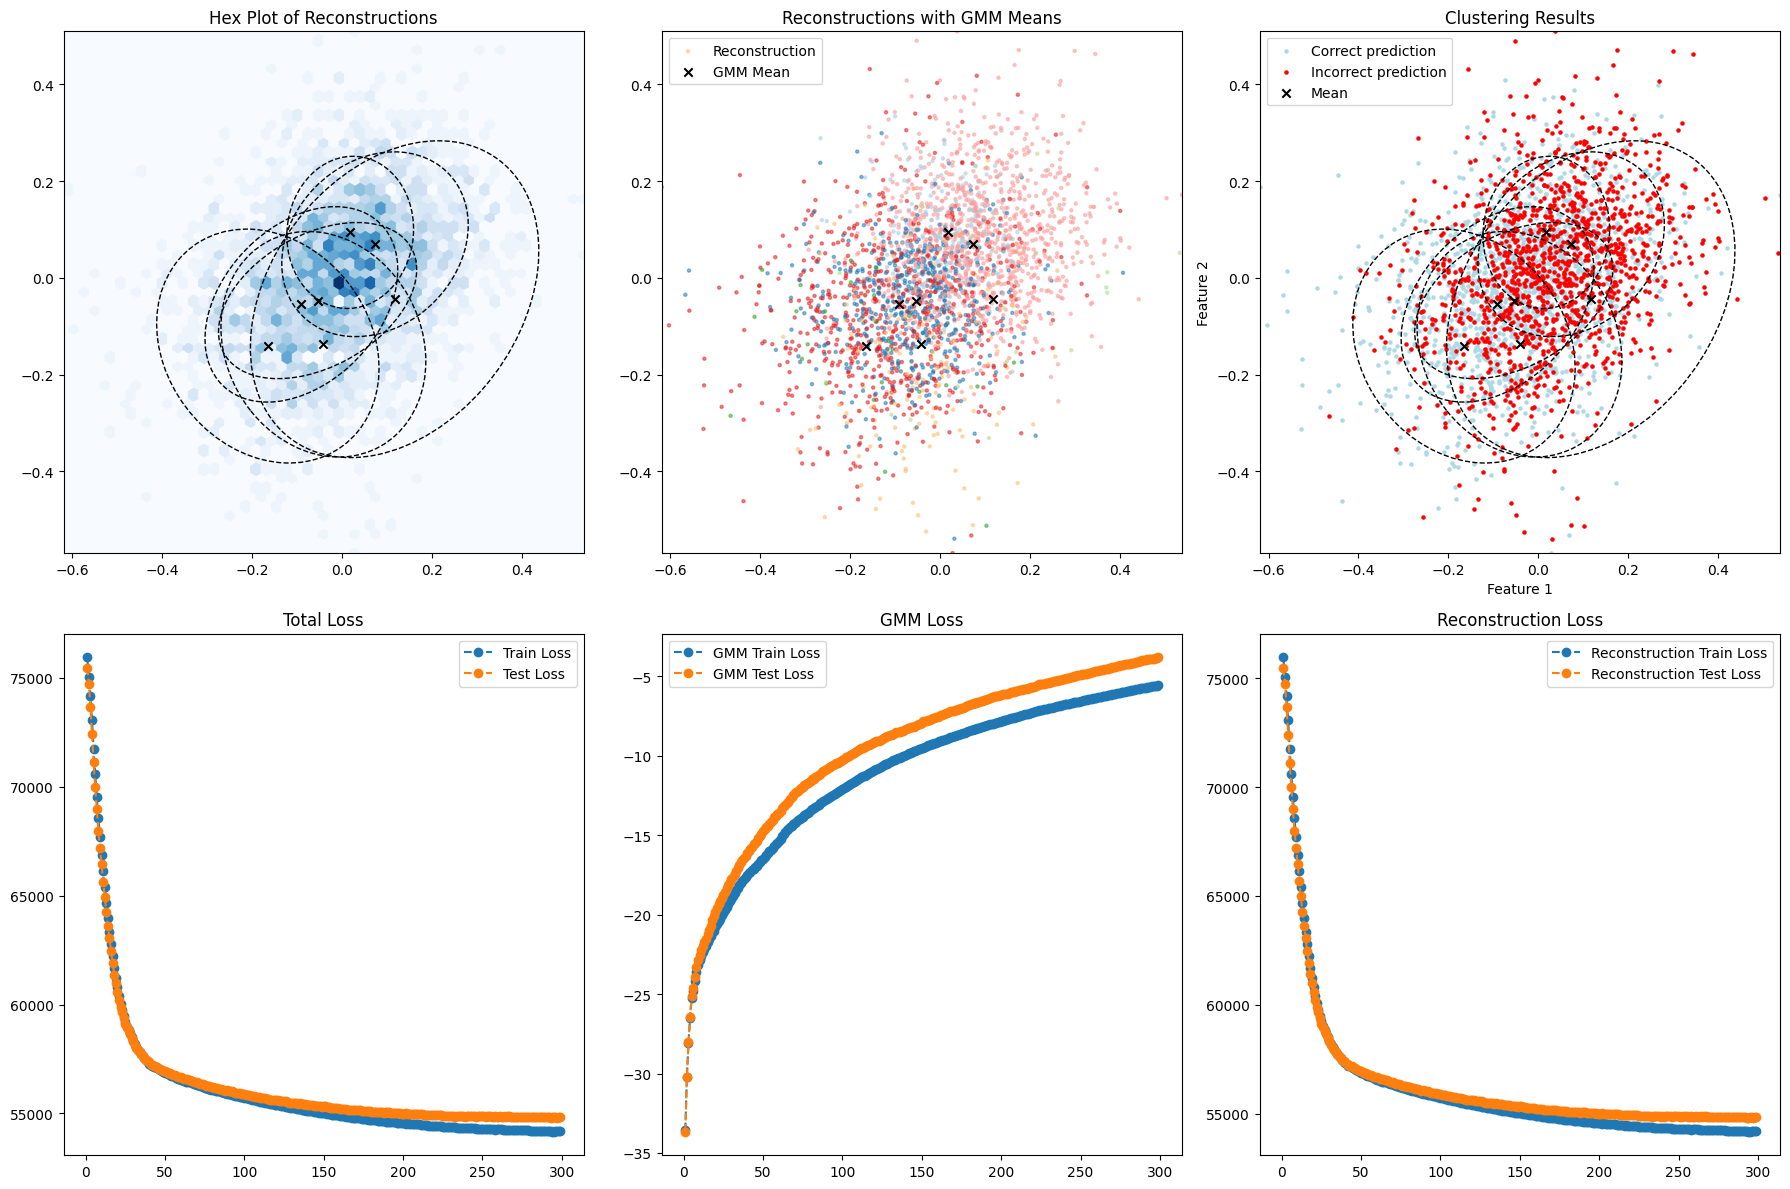

 60%|█████▉    | 300/501 [03:32<03:45,  1.12s/it]

{'rand_score': 0.7736278772354126, 'adjusted_rand_score': 0.364789217710495, 'mutual_info_score': 0.7995957732200623, 'adjusted_mutual_info_score': 0.48702672123908997, 'normalized_mutual_info_score': 0.4873342216014862, 'fowlkes_mallows_score': 0.5146169066429138, 'homogeneity_score': 0.3022170662879944, 'completeness_score': 0.6360518336296082, 'v_measure_score': 0.40974547740742695, 'purity_score': 0.5456562042236328, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.4482521712779999}, 1: {'precision': 0.350844277673546, 'recall': 0.8130434782608695, 'f1-score': 0.490170380078637, 'support': 230, 'jaccard': 0.3246527777777778, 'roc_auc': 0.8260500431060791}, 2: {'precision': 0.34782608695652173, 'recall': 0.014010507880910683, 'f1-score': 0.026936026936026935, 'support': 571, 'jaccard': 0.013651877133105802, 'roc_auc': 0.5002027153968811}, 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 221, 

 70%|██████▉   | 349/501 [04:09<01:59,  1.27it/s]

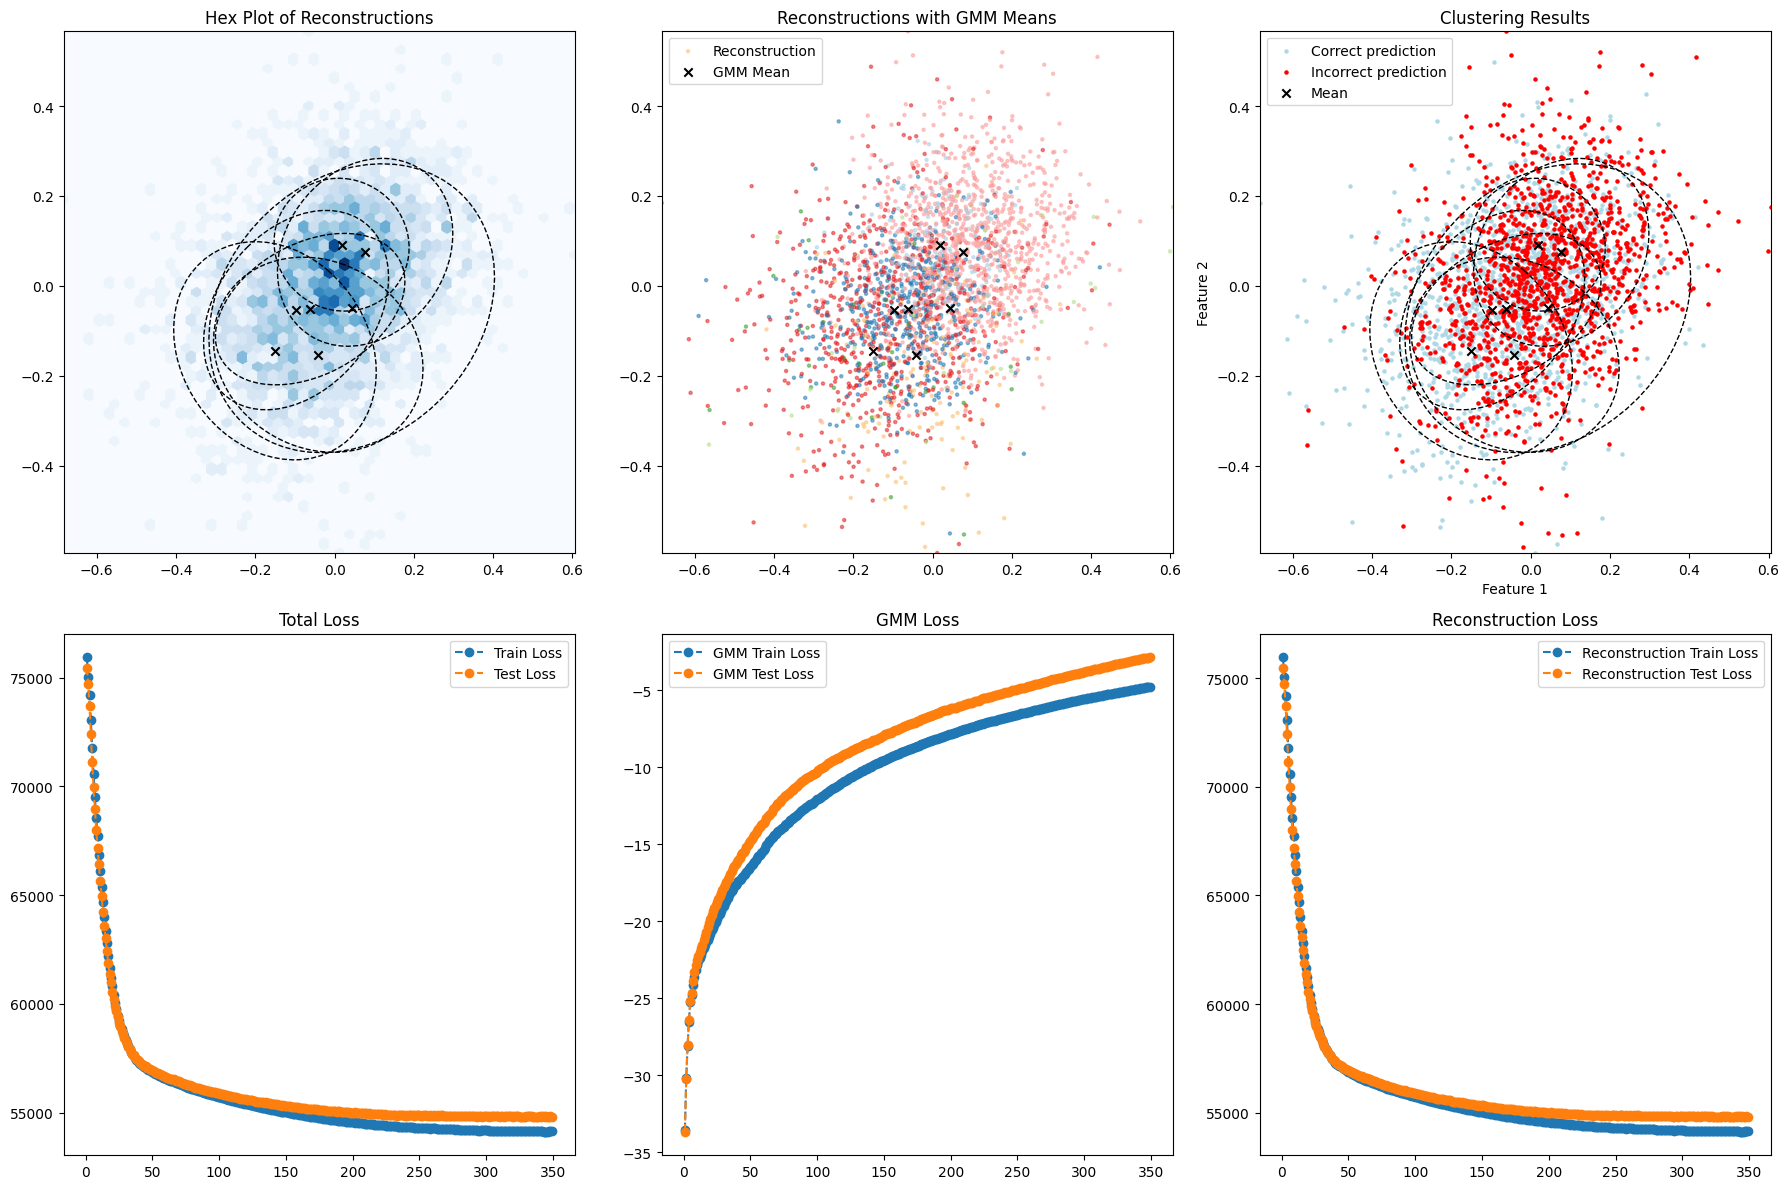

 70%|██████▉   | 350/501 [04:11<02:53,  1.15s/it]

{'rand_score': 0.7669432163238525, 'adjusted_rand_score': 0.34361690282821655, 'mutual_info_score': 0.7884150743484497, 'adjusted_mutual_info_score': 0.47705990076065063, 'normalized_mutual_info_score': 0.477375864982605, 'fowlkes_mallows_score': 0.49684929847717285, 'homogeneity_score': 0.304845929145813, 'completeness_score': 0.6180305480957031, 'v_measure_score': 0.4082975377980632, 'purity_score': 0.5393715500831604, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.4496955871582031}, 1: {'precision': 0.3687258687258687, 'recall': 0.8304347826086956, 'f1-score': 0.5106951871657754, 'support': 230, 'jaccard': 0.34290843806104127, 'roc_auc': 0.8294896483421326}, 2: {'precision': 0.24324324324324326, 'recall': 0.01576182136602452, 'f1-score': 0.02960526315789474, 'support': 571, 'jaccard': 0.015025041736227046, 'roc_auc': 0.49939438700675964}, 3: {'precision': 0.029411764705882353, 'recall': 0.00452488687782805

 80%|███████▉  | 399/501 [04:49<01:16,  1.34it/s]

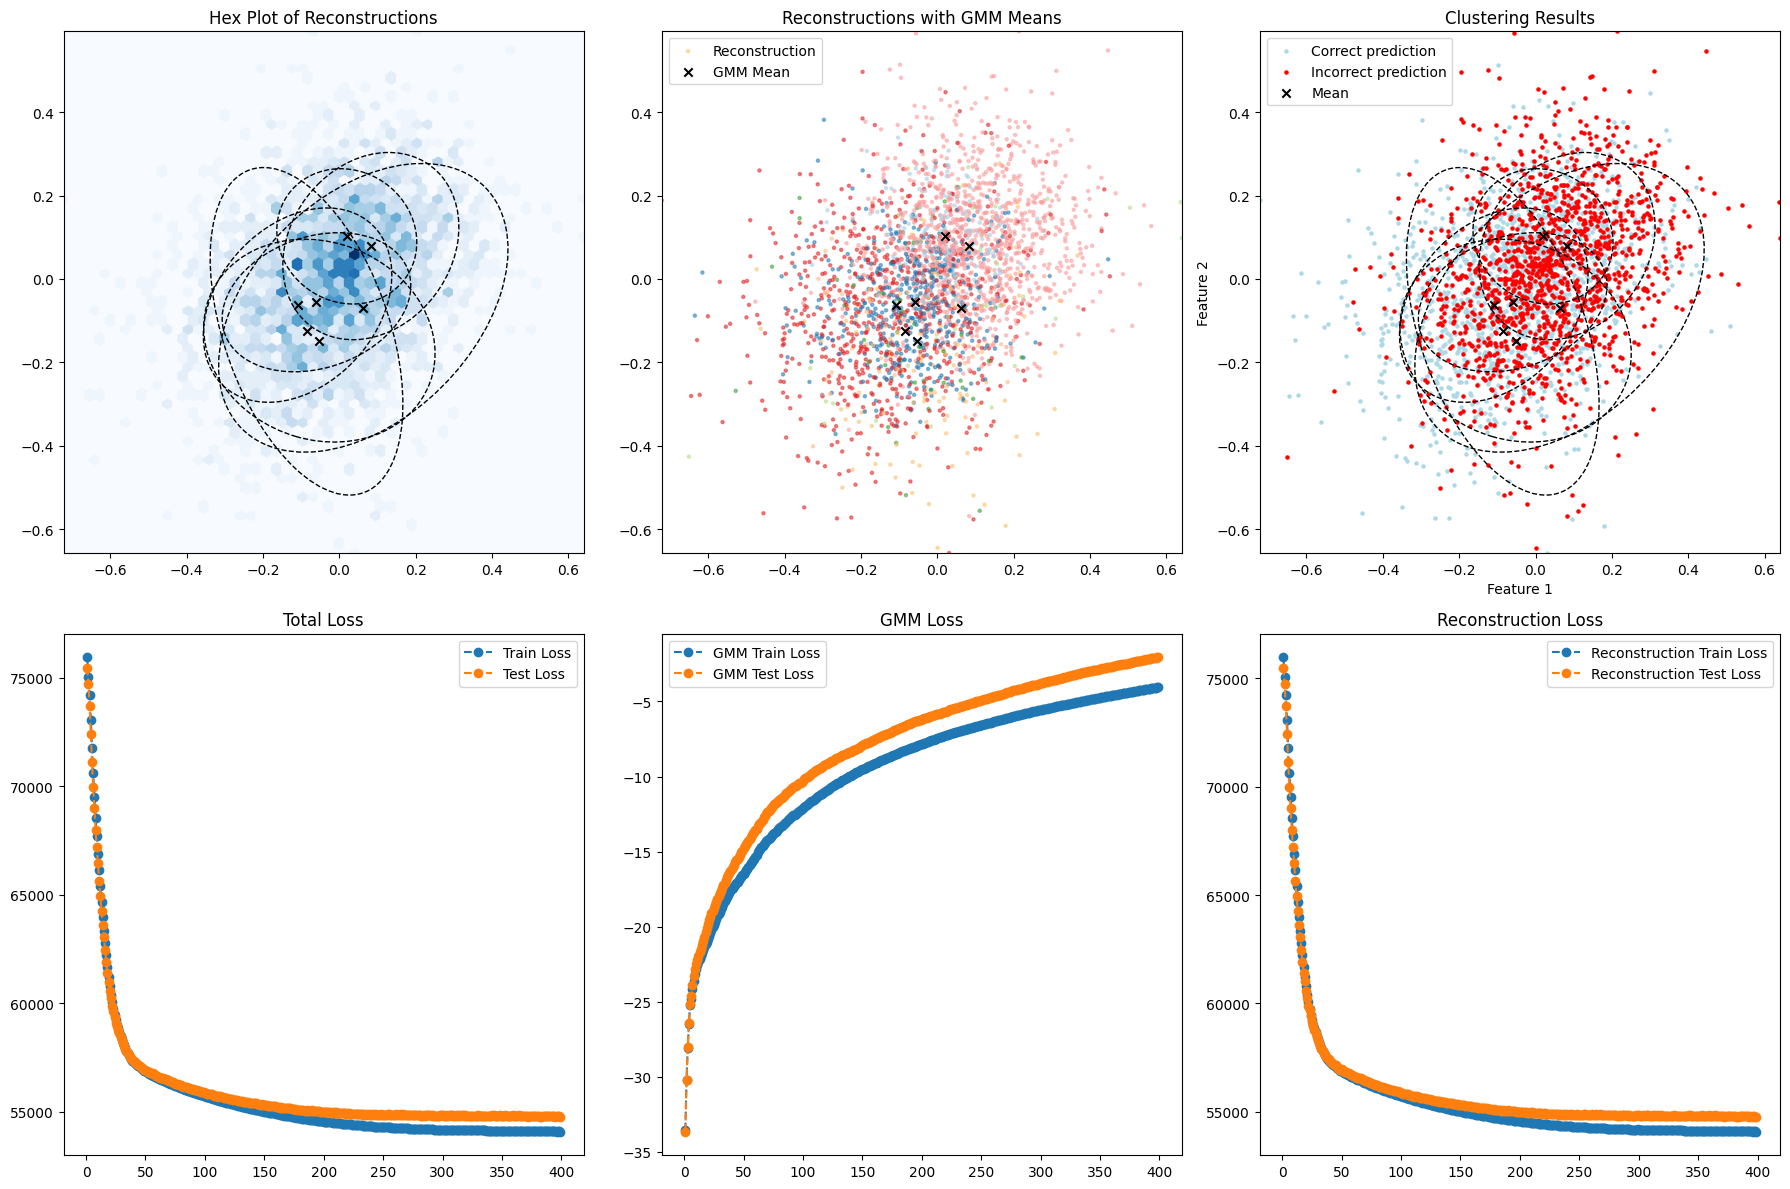

 80%|███████▉  | 400/501 [04:52<02:09,  1.28s/it]

{'rand_score': 0.7637631297111511, 'adjusted_rand_score': 0.33439967036247253, 'mutual_info_score': 0.7518675923347473, 'adjusted_mutual_info_score': 0.45375487208366394, 'normalized_mutual_info_score': 0.45408597588539124, 'fowlkes_mallows_score': 0.4893830418586731, 'homogeneity_score': 0.28428328037261963, 'completeness_score': 0.5933050513267517, 'v_measure_score': 0.3843868478201082, 'purity_score': 0.5319778323173523, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.45030924677848816}, 1: {'precision': 0.3684210526315789, 'recall': 0.7608695652173914, 'f1-score': 0.4964539007092198, 'support': 230, 'jaccard': 0.330188679245283, 'roc_auc': 0.7979815602302551}, 2: {'precision': 0.30303030303030304, 'recall': 0.017513134851138354, 'f1-score': 0.033112582781456956, 'support': 571, 'jaccard': 0.016835016835016835, 'roc_auc': 0.5039662718772888}, 3: {'precision': 0.3023255813953488, 'recall': 0.0588235294117647

 90%|████████▉ | 449/501 [05:30<00:40,  1.27it/s]

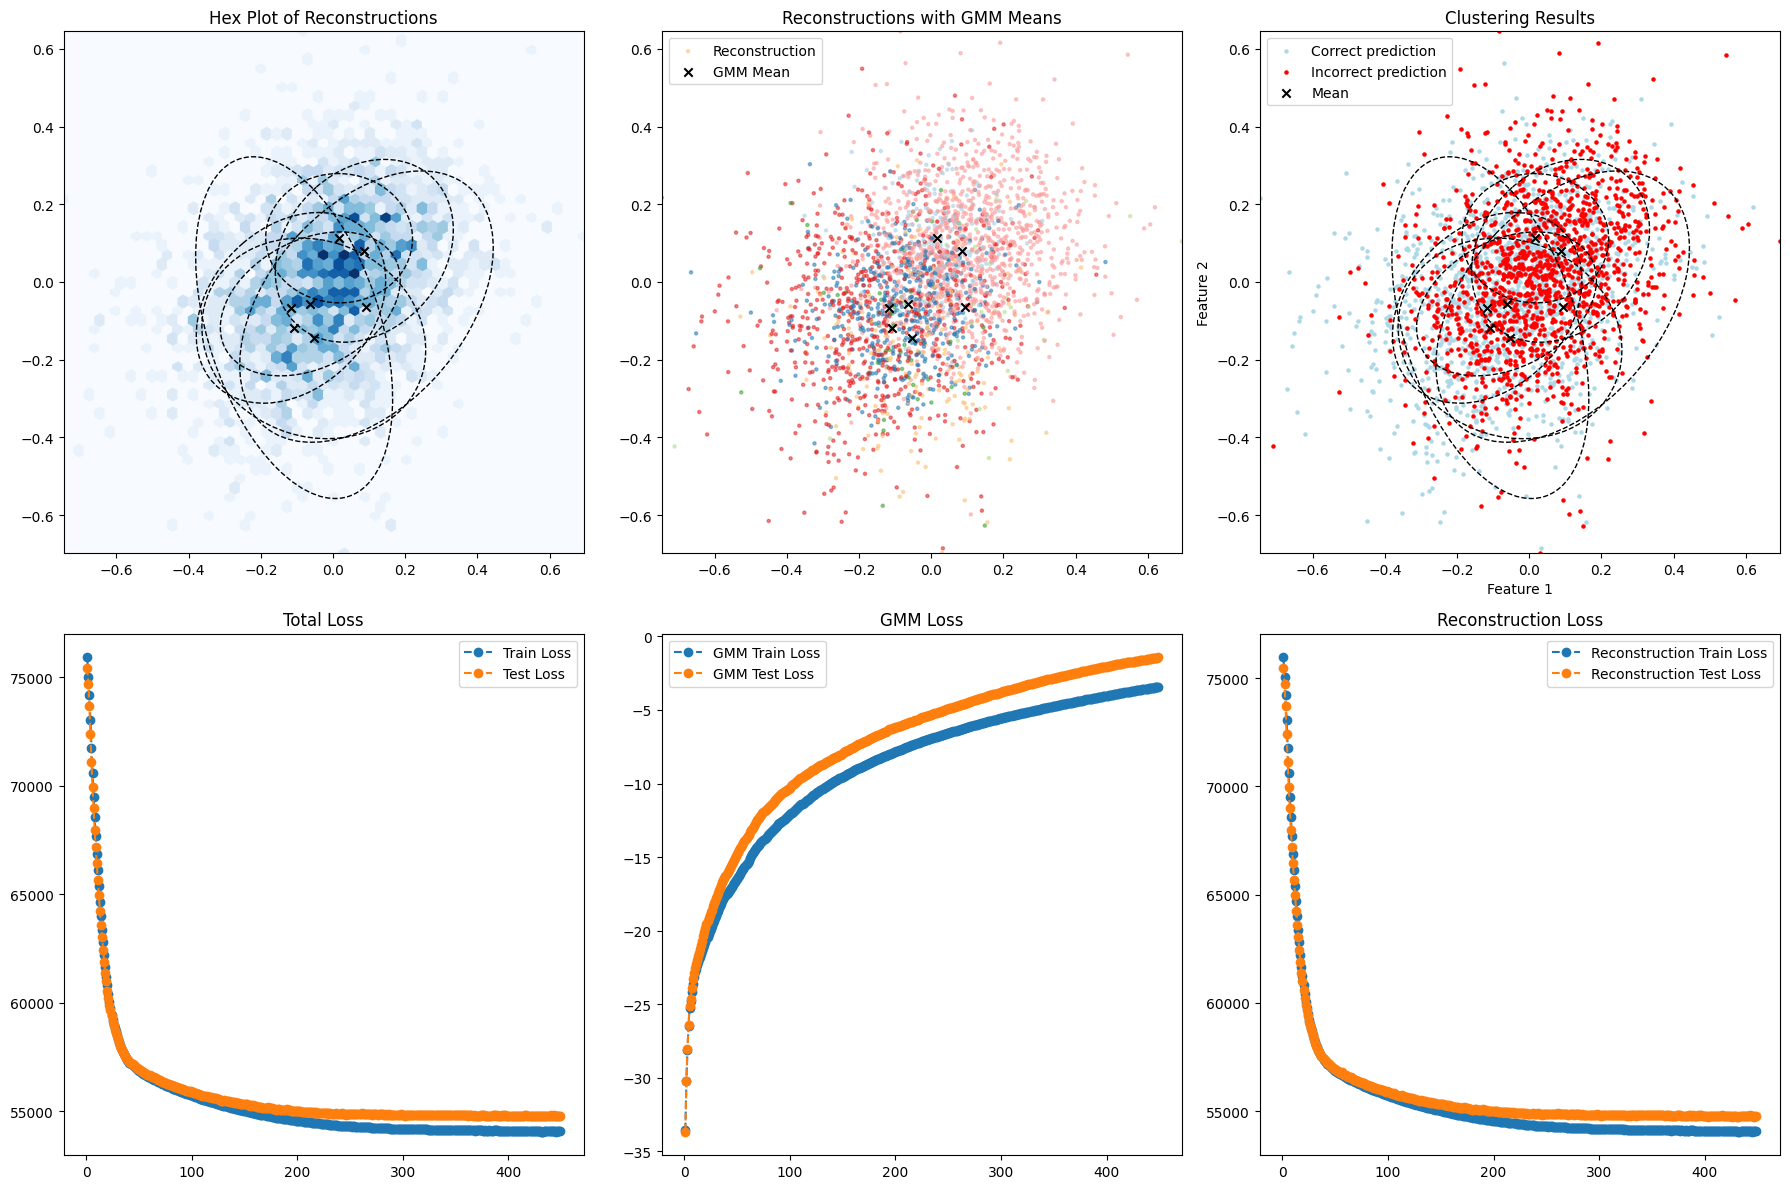

 90%|████████▉ | 450/501 [05:32<01:00,  1.19s/it]

{'rand_score': 0.7608056664466858, 'adjusted_rand_score': 0.3245908319950104, 'mutual_info_score': 0.7407763004302979, 'adjusted_mutual_info_score': 0.4464747905731201, 'normalized_mutual_info_score': 0.44681084156036377, 'fowlkes_mallows_score': 0.4810464382171631, 'homogeneity_score': 0.27891457080841064, 'completeness_score': 0.5848612785339355, 'v_measure_score': 0.37770524056432137, 'purity_score': 0.533086895942688, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.44764697551727295}, 1: {'precision': 0.3657505285412262, 'recall': 0.7521739130434782, 'f1-score': 0.49217638691322896, 'support': 230, 'jaccard': 0.3264150943396226, 'roc_auc': 0.8003073930740356}, 2: {'precision': 0.25806451612903225, 'recall': 0.014010507880910683, 'f1-score': 0.026578073089700997, 'support': 571, 'jaccard': 0.013468013468013467, 'roc_auc': 0.5035609006881714}, 3: {'precision': 0.34146341463414637, 'recall': 0.063348416289592

100%|█████████▉| 499/501 [06:12<00:01,  1.21it/s]

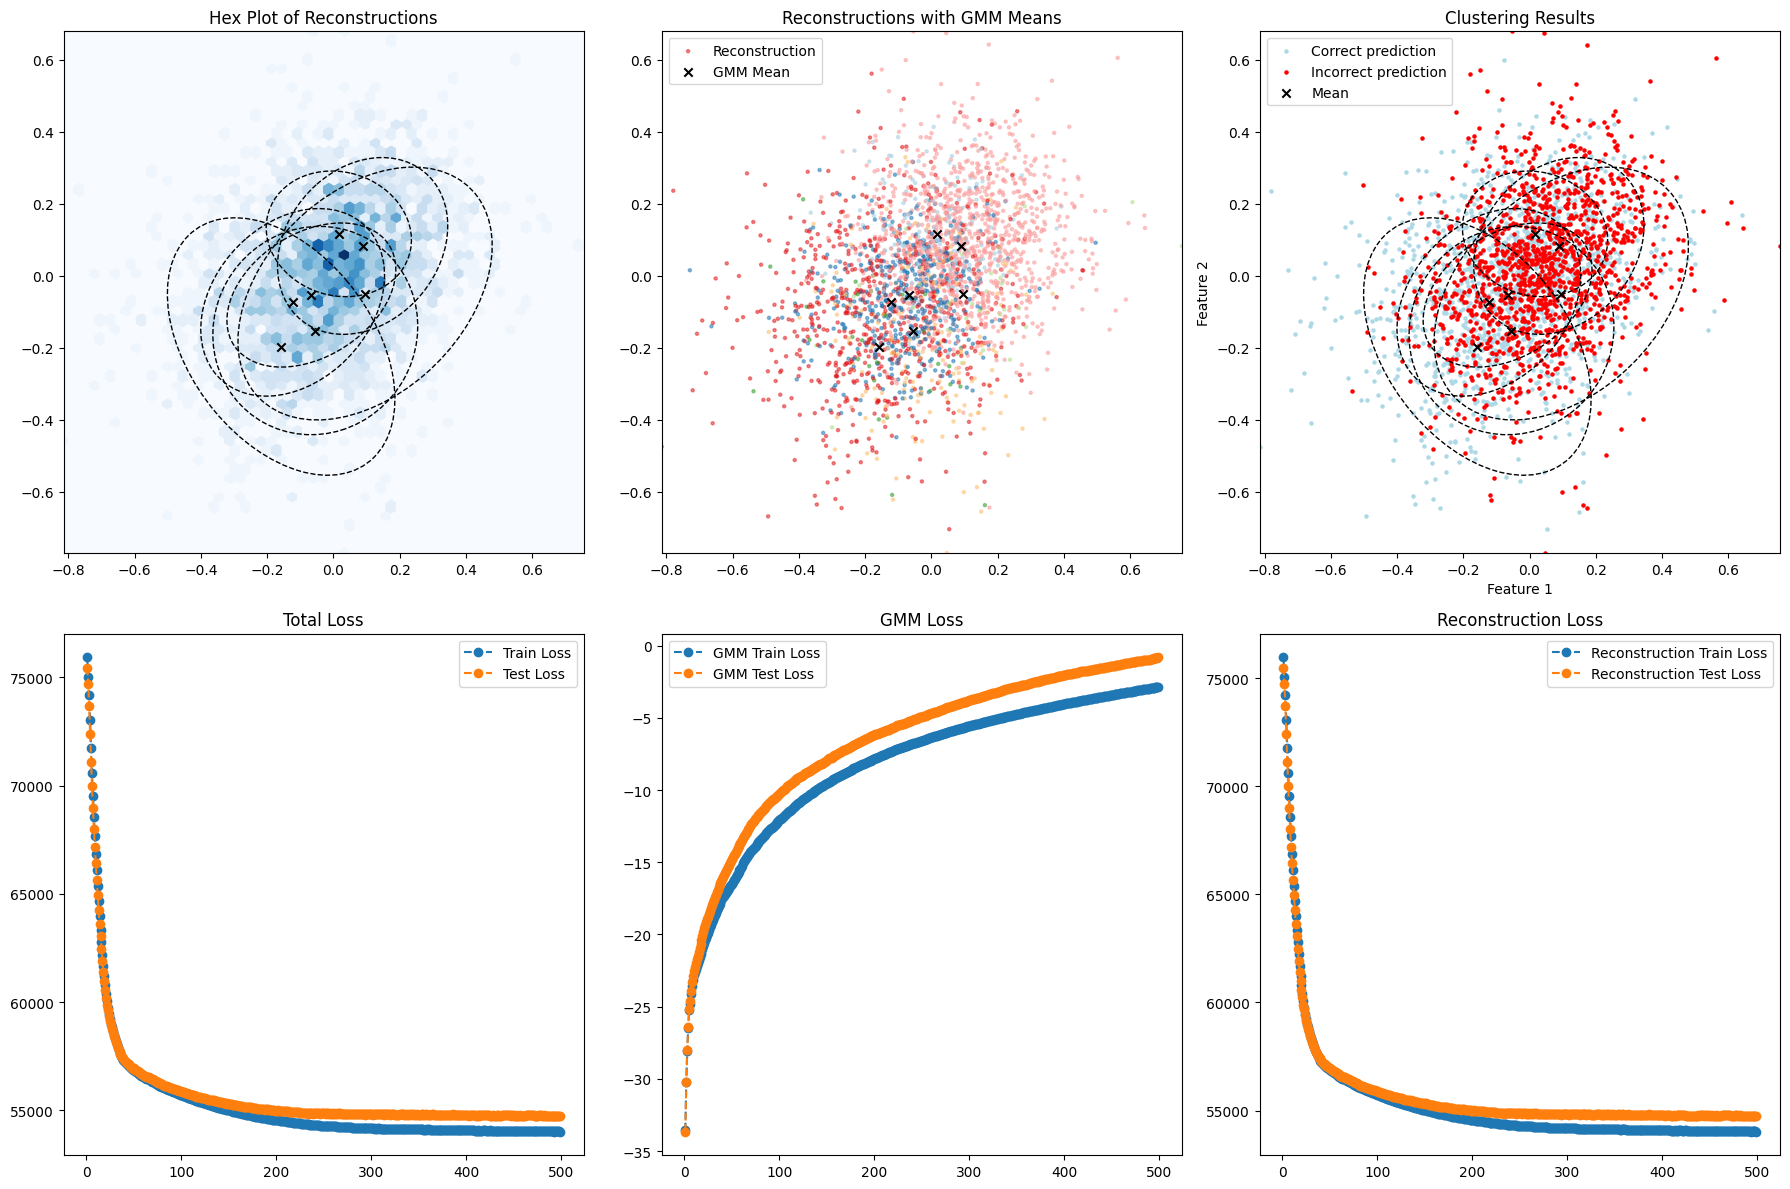

100%|█████████▉| 500/501 [06:14<00:01,  1.24s/it]

{'rand_score': 0.7585951685905457, 'adjusted_rand_score': 0.3221050500869751, 'mutual_info_score': 0.75133216381073, 'adjusted_mutual_info_score': 0.4545266032218933, 'normalized_mutual_info_score': 0.4548562467098236, 'fowlkes_mallows_score': 0.48027926683425903, 'homogeneity_score': 0.2800822854042053, 'completeness_score': 0.5973865389823914, 'v_measure_score': 0.38136371904691074, 'purity_score': 0.533456563949585, 'classification_report': {0: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 720, 'jaccard': 0.0, 'roc_auc': 0.4513902962207794}, 1: {'precision': 0.37553648068669526, 'recall': 0.7608695652173914, 'f1-score': 0.5028735632183908, 'support': 230, 'jaccard': 0.33589251439539347, 'roc_auc': 0.807892918586731}, 2: {'precision': 0.2222222222222222, 'recall': 0.014010507880910683, 'f1-score': 0.026359143327841845, 'support': 571, 'jaccard': 0.01335559265442404, 'roc_auc': 0.5011719465255737}, 3: {'precision': 0.10714285714285714, 'recall': 0.013574660633484163, '

100%|██████████| 501/501 [06:15<00:00,  1.34it/s]


In [16]:
torch.autograd.set_detect_anomaly(True)
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm

y_true = torch.tensor(train_data['label'].values.astype(int), dtype=torch.int64).to(device)

cluster_results = {}

def train_loop(train_loader, test_loader, model, gmm, rep, test_rep, lrs, betas, wd, n_epochs, plot_step=None, plot_skip=0):

    model_optimizer = torch.optim.Adam(model.parameters(), lr=lrs[0], betas=betas, weight_decay=wd)
    rep_optimizer = torch.optim.Adam(rep.parameters(), lr=lrs[1], betas=betas, weight_decay=wd)
    testrep_optimizer = torch.optim.Adam(test_rep.parameters(), lr=lrs[1], betas=betas, weight_decay=wd)

    train_losses = []
    test_losses = []
    gmm_train_losses = []
    gmm_test_losses = []
    recon_train_losses = []
    recon_test_losses = []

    for epoch in tqdm(range(1, n_epochs+1)):
        train_losses.append(0)
        test_losses.append(0)
        gmm_train_losses.append(0)
        gmm_test_losses.append(0)
        recon_train_losses.append(0)
        recon_test_losses.append(0)

        # Training loop
        rep_optimizer.zero_grad()
        for x, scaling, i in train_loader:
            model_optimizer.zero_grad()

            x, scaling, i = x.to(device), scaling.to(device), i.to(device)
            z = rep(i)
            y = model(z)
            recon_loss_x = model.nb.loss(x, scaling.unsqueeze(1), y)
            gmm_error = -torch.sum(gmm.score_samples(z))
            loss = recon_loss_x.clone() + gmm_error.clone()
            loss.backward()

            train_losses[-1] += loss.item()
            gmm_train_losses[-1] += gmm_error.item()
            recon_train_losses[-1] += recon_loss_x.item()
            
            model_optimizer.step()

        rep_optimizer.step()

        # Testing loop
        testrep_optimizer.zero_grad()
        for x, scaling, i in test_loader:
            x, scaling, i = x.to(device), scaling.to(device), i.to(device)
            z = test_rep(i)
            y = model(z)
            recon_loss_x = model.nb.loss(x, scaling.unsqueeze(1), y)
            gmm_error = -torch.sum(gmm.score_samples(z))
            loss = recon_loss_x.clone() + gmm_error.clone()
            loss.backward()

            test_losses[-1] += loss.item()
            gmm_test_losses[-1] += gmm_error.item()
            recon_test_losses[-1] += recon_loss_x.item()

        testrep_optimizer.step()

        with torch.no_grad():
            representations = rep.z.detach().to(device)
            gmm.fit(representations, max_iter = 10, warm_start = True)

        # average the losses
        train_losses[-1] /= len(train_loader.dataset)
        test_losses[-1] /= len(test_loader.dataset)
        gmm_train_losses[-1] /= len(train_loader.dataset)
        gmm_test_losses[-1] /= len(test_loader.dataset)
        recon_train_losses[-1] /= len(train_loader.dataset)
        recon_test_losses[-1] /= len(test_loader.dataset)

        if plot_step is not None and epoch % plot_step == 0 and epoch >= plot_skip:
            y_pred = gmm.predict(rep.z.to(device))
            y_pred = gmm.predict(rep.z.to(device))
            means = gmm.means_
            covars = gmm.covariances_
            weights = gmm.weights_
            plot_gaussian(rep.z, y_true, y_pred, means, covars, train_losses, test_losses, gmm_train_losses, gmm_test_losses, recon_train_losses, recon_test_losses)

            cluster_results[epoch] = gmm.evaluate_clustering(rep.z.to(device), true_labels = y_true)
            print(cluster_results[epoch])

# find ideal number of features
print(train_data.shape[1])
n_features = 10
n_components = 7
nsample = train_data.shape[0]
nsample_test = test_data.shape[0]
lr = 1e-3
lr_rep = 1e-2

gmm = GaussianMixture(n_features, n_components, covariance_type='full', init_params='kmeans', random_state=42, device=device)

rep = RepresentationLayer(values=torch.zeros(size=(nsample,n_features)).to(device))
test_rep = RepresentationLayer(values=torch.zeros(size=(nsample_test,n_features)).to(device))
model = Decoder(latent=n_features, hidden=[64, 128, 64], out=out_dim, r_init=2, scaling_type='mean', activation='relu', dropout_rate=.2).to(device)

train_loop(train_loader, test_loader, model, gmm, rep, test_rep,
           lrs=[lr,lr_rep], betas=(0.5,0.7), wd=1e-4,
           n_epochs=501, plot_step=50, plot_skip=100)